# Proves TFG

In [6]:
import essentia
import math
from essentia import *

import essentia.standard as std
import IPython.display as ipd
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

import librosa
import scipy
from scipy import spatial, signal 

In [2]:
def buscar_frecuencia(texto):
    frecuencias = [20, 30, 40, 60, 80, 120, 160, 240, 320, 480, 640, 960, 1280, 1920, 2560, 3840, 5120, 7680, 10240, 15360, 20480]
    voltajes = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
    for i, voltaje in enumerate(voltajes):
        if str(voltaje) in texto:
            return frecuencias[i]
    return None

In [144]:
def cutFrames(params, input = range(100)):

    if not 'validFrameThresholdRatio' in params:
        params['validFrameThresholdRatio'] = 0
    framegen = std.FrameGenerator(input,
                                frameSize = params['frameSize'],
                                hopSize = params['hopSize'],
                                validFrameThresholdRatio = params['validFrameThresholdRatio'],
                                startFromZero = params['startFromZero'])
                                
    return [ frame for frame in framegen ]


def framesToAudio(frames):
    audio = frames.flatten()      
    return audio

def audioAnalysis(audio, sampleRate):
    #parametros para el cálculos del análisis y sintesis
    params = { 'frameSize': 2048, 'hopSize': 128, 'startFromZero': True, 'sampleRate': sampleRate,
              'maxnSines': 100,'magnitudeThreshold': -74,'minSineDur': 0.02,'freqDevOffset': 10, 
              'freqDevSlope': 0.001, 'maxFrequency': 550.,'minFrequency': 65., 'nHarmonics': 15}
        
    # Creación de funciones utilizadas
    fcut = std.FrameCutter(frameSize=params["frameSize"], hopSize=params["hopSize"], startFromZero=False)
    w = std.Windowing(type="blackmanharris92")
    fft = std.FFT(size=params["frameSize"])
    ifft = std.IFFT(size=params["frameSize"], normalize=False)
    spec = std.Spectrum(size = params['frameSize']);
    pitchDetect = std.PitchYinFFT(frameSize=params['frameSize'], sampleRate =  params['sampleRate']) 
    hprmanal = std.HprModelAnal(nHarmonics = params['nHarmonics'], sampleRate = params['sampleRate'], hopSize = params['hopSize'], maxnSines = params['maxnSines'], magnitudeThreshold = params['magnitudeThreshold'], freqDevOffset = params['freqDevOffset'], freqDevSlope = params['freqDevSlope'], minFrequency =  params['minFrequency'], maxFrequency =  params['maxFrequency'])
    
    #
    signal  = np.append(audio, zeros(params['frameSize'] // 2))
    frames = cutFrames(params, signal)
    
    # 
    mags_list = []
    freqs_list = []
    phases_list = []
    res_list = []
    for f in frames:
        # analysis
        win = w(f)
        spectrum = spec(win)
        pitch, pitchConf = pitchDetect(spectrum)
        frequencies, magnitudes, phases, res = hprmanal(f, pitch)
        
        magnitudes64 = np.round(np.float64(magnitudes), 5)
        frequencies64 = np.round(np.float64(frequencies), 5)
        phases64 = np.round(np.float64(phases), 5)
        res64 = np.round(np.float64(res), 5)
        
        
        mags_list.append(magnitudes64)
        freqs_list.append(np.float64(frequencies64))
        phases_list.append(np.float64(phases64))
        res_list.append(np.float64(res64))
        
    return mags_list, freqs_list, phases_list, res_list, params

def audioSynthesis(sampleRate, frameSize, hopSize, magnitudes, frequencies, phases, res):
    
    synFFTSize = min(int(frameSize/4), 4*hopSize)  # make sure the FFT size is appropriate
    smsyn = std.SprModelSynth(sampleRate=sampleRate,
                                 fftSize=synFFTSize,
                                 hopSize=hopSize)
    outsignal = []
          
    for f in range(len(magnitudes)):
        frames, sineframes, resframes = smsyn(magnitudes[f], frequencies[f], phases[f], res[f])
        outsignal = np.append(outsignal, frames)
    
    outsignal = outsignal [2*hopSize:] # audio sintetizado
    return outsignal

def cut_audio_x_periods(audio, sampleRate, periods = None):
    
    #obtener versión del audio de solo X periodos
    if periods == None:
        return audio
    else:
        freq_fund_teorica = buscar_frecuencia(file_name)

        # Realizar la transformada de Fourier
        fft = np.fft.fft(audio)

        # Obtener la amplitud de la transformada
        magnitude = np.abs(fft)

        # Obtener las frecuencias correspondientes
        frequencies = np.fft.fftfreq(len(audio), 1/sampleRate)

        # Encontrar la frecuencia fundamental
#         for i in range(len(magnitude)):
#             if magnitude[i]>100:
#                 freq_fund_calculada = np.abs(frequencies[i])
#                 break
#         print('Frequencia fund. del señal calculada: ' + str(freq_fund_calculada))
#         print('Frequencia fund. del señal según la tabla: ' + str(freq_fund_teorica))

        #Esta forma no siempre funciona ya que la frec. fundamental puede tenr un harmonico de mayor magnitud que ella misma
        # fundamental_freq = np.abs(frequencies[np.argmax(magnitude)])

        # calcular la duración de un periodo en SEGUNDOS i SAMPLES
        period = np.abs(1/freq_fund_teorica)
        period_samples = int(period*sampleRate)
        print('Samples por periodo: ' + str(period_samples))

        # Calcular el número de períodos actuales en el audio
        num_periods = int(len(audio) / period_samples)
        print('Numero de periodos total del audio original: '+ str(num_periods))
        #obtener versión del audio de solo 1 periodo
        audio_cut = audio[:period_samples*periods]

        return audio_cut

# loader = std.MonoLoader(filename = str(input_file), sampleRate=params["sampleRate"])
# audio = loader()

# mags_list, freqs_list, phases_list, res_list = audioAnalysis(input_file)
# outsignal = audioSynthesis(params, mags_list, freqs_list, phases_list, res_list)


# plt.plot(audio)
# plt.plot(outsignal)

# plt.show()
# ipd.display(ipd.Audio(data=audio, rate=params["sampleRate"]))
# ipd.display(ipd.Audio(data=outsignal, rate=params["sampleRate"]))

In [58]:
import json
import os

def generateJSON(filepathJSON, filepathAudio, signalName, numPeriods = None):
    #cargar audio y valor de sample rate
    audio, sampleRate = librosa.load(filepathAudio)
    
    #cortar audio a numero de periodos deseado (si se escoge)
    audio_cut = cut_audio_x_periods(audio, sampleRate, numPeriods)
    
    #generar analisis del audio
    mags, freqs, phases, res, params = audioAnalysis(audio_cut, sampleRate)
#     mags_np = np.array(mags, dtype=np.float64).tobytes()
    
    listObj = {
                    "Signal Name": signalName,
                    "Sample Rate": params["sampleRate"],
                    "Frame Size": params["frameSize"],
                    "Hop Size": params['hopSize'],
                    "Harmonic Magnitud": [m.tolist() for m in mags],
                    "Harmonic Frequency": [f.tolist() for f in freqs],
                    "Harmonic Phase": [p.tolist() for p in phases],
                    "Harmonic Res": [r.tolist() for r in res],
                }
    
#     with open('Hamonic Magnitud', 'wb') as file:
#         file.write(mags_np)
        
    with open(filepathJSON, 'w') as file:
            json.dump(listObj, file,
                            separators=(',',': '))


            



In [151]:
filepath = 'test.json'
input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular-sawtooth +/vco1_5.0_tri-saw+.wav'
input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/square/vco1_9.0_sqr.wav'

file_name = input_file.split("/")[-1] #cortar solamente el nombre del archivo

generateJSON(filepath, input_file, file_name, 1000)

Samples por periodo: 2
Numero de periodos total del audio original: 27526


Samples por periodo: 2
Numero de periodos total del audio original: 27526


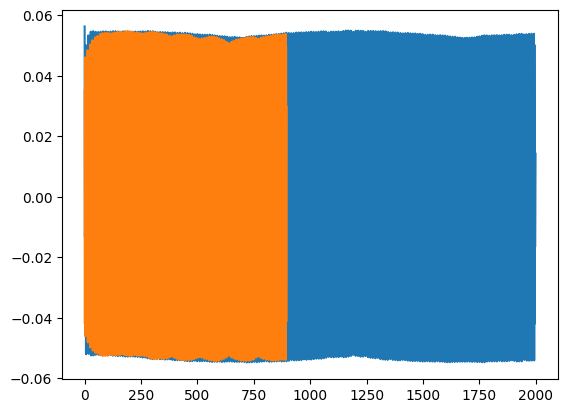

In [152]:
def readJSON(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
        
    return (data["Signal Name"],
            data["Sample Rate"],
            data["Frame Size"],
            data["Hop Size"],
            data["Harmonic Magnitud"], 
            data["Harmonic Frequency"],
            data["Harmonic Phase"],
            data["Harmonic Res"])


filepath = 'test.json'



name, sampleRate, frameSize, hopSize, mags, freqs, phases, res = readJSON(filepath)
outsignal = audioSynthesis(sampleRate, frameSize, hopSize, mags, freqs, phases, res)

#cargar audio y valor de sample rate
audio, sampleRate = librosa.load(input_file)
audio_cut = cut_audio_x_periods(audio, sampleRate, 1000)

plt.plot(audio_cut)
plt.plot(outsignal)

plt.show()
ipd.display(ipd.Audio(data=audio_cut, rate=sampleRate))
ipd.display(ipd.Audio(data=outsignal, rate=sampleRate))

## *!Warning!*
## Generador de archivos JSON para todos los audios, en sus respectivas carpetas

In [7]:
import os
import glob
path = '/mnt/c/Users/bosco/Desktop/TFG/rsf_kobol_expander_2-vco/audio/vco1/' # Reemplazar con la ruta donde están las carpetas
file_list = [] # para almacenar los nombres de archivo


for folder in os.listdir(path):
    folder_path = os.path.join(path, folder) # ruta a cada carpeta
    for file in glob.glob(os.path.join(folder_path, '*.wav')): # busca todos los archivos con la extensión .audio_extension en cada carpeta
#         file_list.append(os.path.basename(file)) # agrega el nombre de archivo a la lista
        
        # carrgar todos los audios y dar audios para comparar
        fileAudio = os.path.basename(file)
        filepathAudio = folder_path + '/' + fileAudio
        print(filepathAudio)
        filepathJSON = filepathAudio.replace('rsf_kobol_expander_2-vco/audio', 'json_files')       
        print(filepathJSON)
        
        generateJSON(filepathJSON, filepathAudio, fileAudio)
        
        
        
#         outsignal = audioSynthesis(params, mags_list, freqs_list, phases_list, res_list)
        
#         loader = std.MonoLoader(filename = str(filepathAudio), sampleRate=params["sampleRate"])
#         audio = loader()
        
#         ipd.display(ipd.Audio(data=file, rate=params["sampleRate"]))
#         ipd.display(ipd.Audio(data=outsignal, rate=params["sampleRate"]))



print(file_list)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/bosco/Desktop/TFG/rsf_kobol_expander_2-vco/audio/vco1/'

In [95]:
#FUNCION DE SIMILITUD - MFCC Y SMILITIUD COSENO

def similitud_coseno_MFCC(original, remake):
    original_mfcc = librosa.feature.mfcc(y=original,sr=sampleRate)
    syntesis_mfcc = librosa.feature.mfcc(y=remake,sr=sampleRate)

    print(original_mfcc.shape)
    print(syntesis_mfcc.shape)

    n = syntesis_mfcc.shape[1]
    coss_sim = np.zeros(n)

    for i in range(n):
        original = original_mfcc[1:, i]
        syntesis = syntesis_mfcc[1:, i]
        coss_sim[i] = 1 - spatial.distance.cosine(original, syntesis)


    similitud_value = np.round(np.mean(coss_sim),4)
    print("Similitud coseno entre MFCC, media = "+str(similitud_value))
          
    return similitud_value

similitud_coseno_MFCC(audio_cut, outsignal)

(20, 8)
(20, 6)
Similitud coseno entre MFCC, media = 0.9494


0.9494

## Calculo de la frecúencia fundamental y plots

Frequencia fund. del señal calculada: 37.784131965233186
Frequencia fund. del señal según la tabla: 40


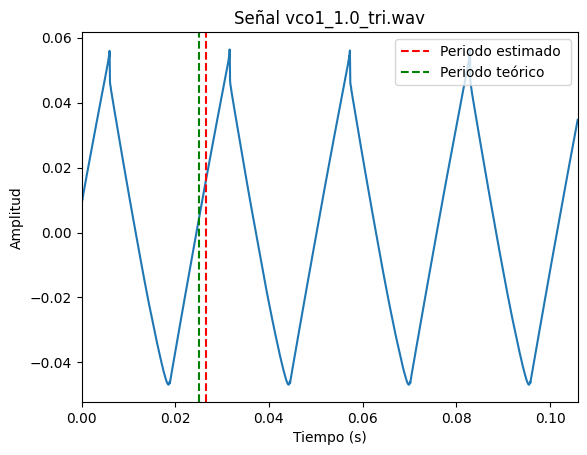

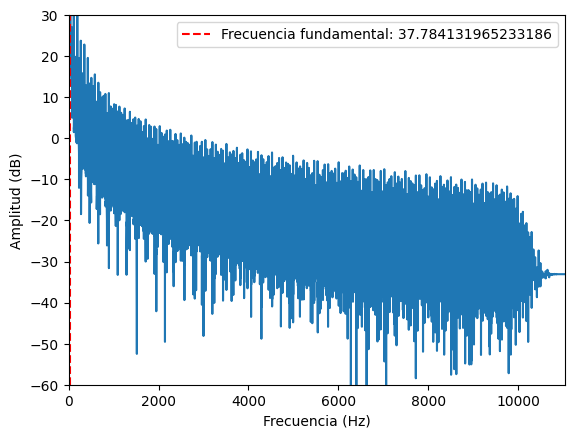

In [16]:
# input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/sawtooth/vco1_1.0_saw.wav'
input_file = '/mnt/c/Users/bosco/Desktop/TFG/TFG-Kobol-BoscoOlives/rsf_kobol_expander_2-vco/audio/vco1/triangular/vco1_1.0_tri.wav'

file_name = input_file.split("/")[-1]

freq_fund_teorica = buscar_frecuencia(file_name)

audio, sampleRate = librosa.load(input_file)


# Realizar la transformada de Fourier
fft = np.fft.fft(audio)

# Obtener la amplitud de la transformada
magnitude = np.abs(fft)

# Obtener las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(audio), 1/sampleRate)

# Encontrar la frecuencia fundamental
for i in range(len(magnitude)):
    if magnitude[i]>100:
        freq_fund_calculada = np.abs(frequencies[i])
        break

#Esta forma no siempre funciona ya que la frec. fundamental puede tenr un harmonico de mayor magnitud que ella misma
# fundamental_freq = np.abs(frequencies[np.argmax(magnitude)])


# Calcular el periodo estimado
period = 1 / fundamental_freq

period = np.abs(period)


print('Frequencia fund. del señal calculada: ' + str(freq_fund_calculada))
print('Frequencia fund. del señal según la tabla: ' + str(freq_fund_teorica))

# Calcular la duración total de la señal
total_time = len(audio) / sampleRate

# Definir los límites del eje x como un rango que cubra 4 veces el período
x_lim = [0, 4 * period]

# Realizar el plot de la señal
plt.plot(np.arange(len(audio)) / sampleRate, audio)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Señal ' + file_name)
plt.axvline(x=period, color='r', linestyle='--', label='Periodo estimado ')
period_theoric = 1/freq_fund_teorica


plt.axvline(x=period_theoric, color='g', linestyle='--', label='Periodo teórico')

plt.legend()
plt.xlim(x_lim)
plt.show()


# Ejemplo de como visualizar  el espectro y marcar la freq. fundamental

# Plot del espectro de frecuencias
plt.plot(frequencies[:len(frequencies)//2], 20 * np.log10(magnitude[:len(magnitude)//2]))
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Amplitud (dB)")
plt.xlim([0, sampleRate/2])
plt.ylim([-60, 30])

plt.axvline(x=freq_fund_calculada, color='r', linestyle='--', label='Frecuencia fundamental: ' + str(freq_fund_calculada))
plt.legend()
plt.show()

# Autocorrelación del primer periodo con el segundo periodo

(551,)
(551,)


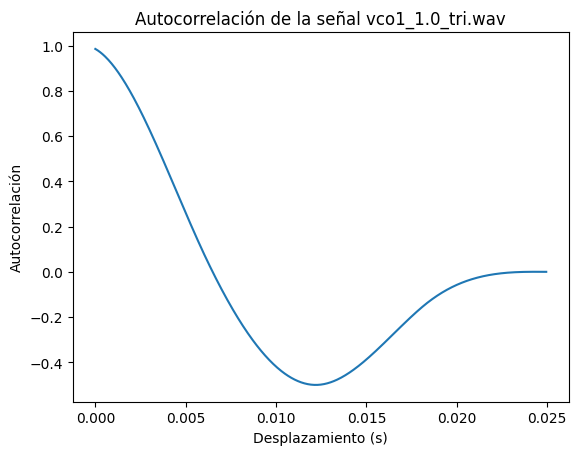

In [85]:
# Calcular el periodo estimado en muestras
period_duration = int(sampleRate / freq_fund_teorica)

# Obtener el primer periodo
primer_periodo = audio[:period_duration]
segundo_periodo = audio[period_duration:period_duration*2]
print(primer_periodo.shape)
print(segundo_periodo.shape)
# Calcular la autocorrelación del primer periodo con el resto de periodos
autocorrelacion = np.correlate(primer_periodo, segundo_periodo, mode='full')

# Normalizar la autocorrelación
autocorrelacion = autocorrelacion[period_duration-1:] / np.max(autocorrelacion)

# Plotear la autocorrelación
plt.plot(np.arange(0, len(autocorrelacion)) / sampleRate, autocorrelacion)
plt.xlabel('Desplazamiento (s)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la señal ' + file_name)
plt.show()

# Autocorrelación del primer periodo con los siguientes 10 periodos

(47806,)
(5510,)


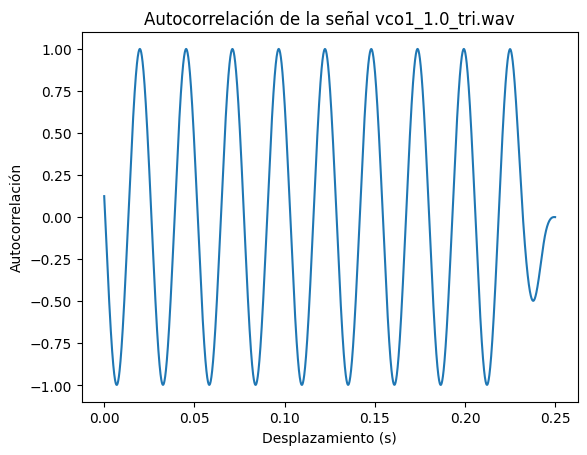

In [91]:

# Calcular el periodo estimado en muestras
period_duration = int(sampleRate / freq_fund_teorica)

# Obtener el primer periodo
print(audio.shape)
primer_periodo = audio[:period_duration]

audio_10_period = audio[:period_duration*10]

# Calcular la autocorrelación del primer periodo con el resto de periodos
autocorrelacion = np.correlate(primer_periodo, audio_10_period, mode='full')

# Normalizar la autocorrelación
autocorrelacion = autocorrelacion[period_duration-1:] / np.max(autocorrelacion)

# Plotear la autocorrelación
plt.plot(np.arange(0, len(autocorrelacion)) / sampleRate, autocorrelacion)
plt.xlabel('Desplazamiento (s)')
plt.ylabel('Autocorrelación')
plt.title('Autocorrelación de la señal ' + file_name)
plt.show()